# 1 Setting up Pyspark

In [1]:
!pwd

/home/ubuntu/mids/capstone-210-spring2024/src/notebooks


In [2]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Install Java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark
#if os.path.isfile("./spark-3.5.1-bin-hadoop3.tgz") == False:
#    !wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Unzip the file
#!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setup environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/home/ubuntu/spark-3.5.1-bin-hadoop3'

# Import findspark and load it
#!pip install -q findspark
import findspark
findspark.init()

# import spacy for NLP and re for regular expressions
import spacy
spacy.cli.download("en_core_web_sm")
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.executor.memory', "24g")\
        .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/02 22:33:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

# 2 Import libraries

In [5]:
import time
import json
import pickle
import urllib.request
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.pandas as ps
import seaborn as sns
#import altair as alt
import pandas as pd
from sklearn.metrics import classification_report, fbeta_score

/home/ubuntu/spark-3.5.1-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [6]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from wordcloud import WordCloud

In [7]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import datetime
from pyspark.sql.functions import lit

# 3 Load data

### 3.1 Obtain stratified training and test splits

In [8]:
#train_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/train_merged_data_conversations'
#test_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/test_merged_data_conversations'

#train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
#test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [9]:
train_merged_data_conversations_path = 's3a://capstone210/data/train_merged_data_conversations/'
test_merged_data_conversations_path = 's3a://capstone210/data/test_merged_data_conversations/'

train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

24/03/02 22:33:03 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [10]:
#train_df_final = df.filter(col('source') != 'PAN12-test')
train_df_final = train_merged_data_conversations_df
test_df_final = test_merged_data_conversations_df

In [11]:
train_df_final.take(1)

[Row(conversation_id='0000604306a283600b730276a2039471', source='PAN12-train', label=0, conversation_start_time='13:04', n_people_in_conversation=4, type_conversation='Group', merged_text="e3fb62ebfa4f36acf5cbff6a6ed0f2e0: can I have your ear? e3fb62ebfa4f36acf5cbff6a6ed0f2e0: i am wondering if Opera implements, or plans to implement safari's &quot;device-pixel-ratio&quot; css media query. would you know? yes e.g. 1 CSS pixel to 3 device pixels would be 3.0 it's one-dimentional well it's explained here http://webkit.org/blog/55/high-dpi-web-sites/ though hyatt hasn't written up a formal defn i think no the ratio is applied in both directions think of it as the sqrt of the difference in number of pixels or better yet, think of it as the zoom factor 200% zoom would produce a factor of 2.0  (i.e. 2.0 squared more pixels per image) okay :) so I'm guessing opera doesn't support it yet. who would be the person to speak to about getting it implemented? where to? should I request an account or

In [12]:
train_df_final.show()

+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|n_texts|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|0000604306a283600...|PAN12-train|    0|                  13:04|                       4|            Group|e3fb62ebfa4f36acf...|9fdcde97c1cb33fe4...|     67|
|0001347c00d419eb5...|PAN12-train|    0|                  13:34|                       2|             Pair|asl say asl and i...|67952953f11f8800a...|      4|
|000197b21283dc478...|PAN12-train|    0|                  06:27|                       2|             Pair|joint in my hand ...|487862cd4ec27d841...|     43|
|0002ee38ac5e78e7e...|PAN12-train|    0|            

In [13]:
train_df_final.count()

87997

In [14]:
train_df_final.groupBy('label')\
              .agg(count('*').alias('count'))\
              .show(truncate = False)

+-----+-----+
|label|count|
+-----+-----+
|1    |2584 |
|0    |85413|
+-----+-----+



In [15]:
train_df_final.filter(col('label').isin([1])).show(truncate = True)

+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|n_texts|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|0014c1b4278df4bf8...|PAN12-train|    1|                  22:14|                       2|             Pair|hi how r ya? was ...|970f6cbfa8b792424...|    131|
|002ec0725fbeb1f5a...|PAN12-train|    1|                  08:08|                       1|        Monologue|                  hi|c62283536cf6261e5...|      1|
|0042866de4da52869...|PAN12-train|    1|                  20:49|                       1|        Monologue|        guess u left|fac3a2081264f1dbb...|      1|
|0063692c957229db0...|PAN12-train|    1|            

In [16]:
test_df_final.count()

155128

In [17]:
test_df_final.groupBy('label')\
             .agg(count('*').alias('count'))\
             .show(truncate = False)

+-----+------+
|label|count |
+-----+------+
|1    |2895  |
|0    |152233|
+-----+------+



# 4 Prepare Data and Tokenization


## 4.1 Type Casting and Clean up Labels

In [18]:
train_df_final.dtypes

[('conversation_id', 'string'),
 ('source', 'string'),
 ('label', 'int'),
 ('conversation_start_time', 'string'),
 ('n_people_in_conversation', 'int'),
 ('type_conversation', 'string'),
 ('merged_text', 'string'),
 ('merged_text_id', 'string'),
 ('n_texts', 'int')]

In [19]:
train_df_final = train_df_final.dropna()

In [20]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



In [21]:
#train_df_final = train_df_final.filter((col('label') == 1) | (col('label') == 0))

In [22]:
train_df_final.summary().show()

24/03/02 22:33:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+----------+--------------------+-----------------------+------------------------+-----------------+--------------------+--------------------+------------------+
|summary|     conversation_id|    source|               label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|           n_texts|
+-------+--------------------+----------+--------------------+-----------------------+------------------------+-----------------+--------------------+--------------------+------------------+
|  count|               87997|     87997|               87997|                  87997|                   87997|            87997|               87997|               87997|             87997|
|   mean|             10534.5|      NULL|0.029364637430821506|                   NULL|       2.263758991783811|             NULL|2.502527525250252...|                NULL|14.464049910792413|
| stddev|    6082.52942176745|      NULL| 0.1

In [23]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



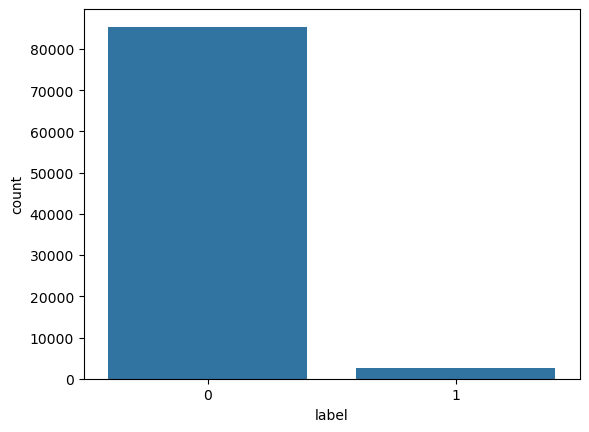

In [24]:
train_df_pandas = train_df_final.select('label').toPandas()
ax = sns.countplot(x="label", data=train_df_pandas)

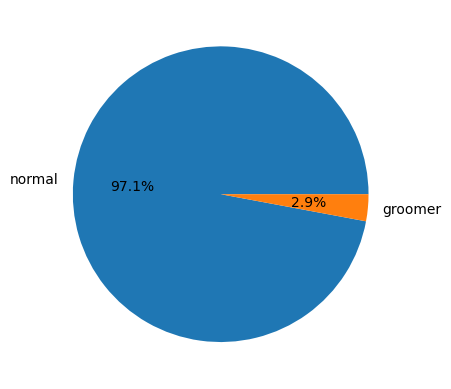

In [25]:
plt.pie(train_df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
plt.show()

In [26]:
# function to undersample dataset automatically
def undersample(df, outcome_col, seed=1234):
  # Split dataset based on outcome
  split0_df = df.filter(col(outcome_col) == 0)
  split1_df = df.filter(col(outcome_col) == 1)
  # determine which split is major vs minor
  if (split0_df.count() > split1_df.count()):
    major_df = split0_df
    minor_df = split1_df
  else:
    minor_df = split0_df
    major_df = split1_df
  ratio = major_df.count()/minor_df.count()
  print("Ratio of major vs minor before sampling: {}".format(ratio))
  # Start under-sampling with Spark
  sampled_majority_df = major_df.sample(False, 1/ratio, seed)
  combined_df = sampled_majority_df.unionAll(minor_df)
  print(f"Final sample size: {combined_df.count()}")
  return combined_df

Ratio of major vs minor before sampling: 33.05456656346749


Final sample size: 5239


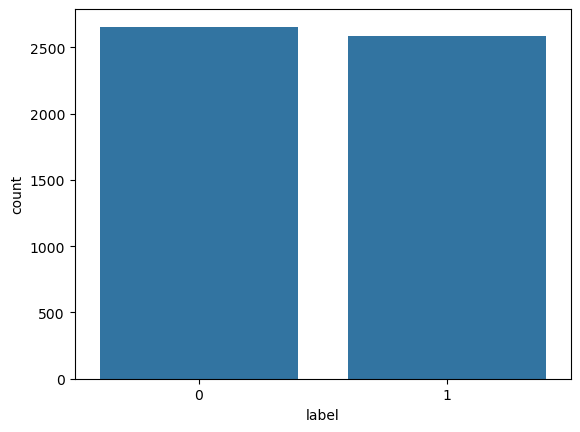

In [27]:
# Perform undersampling technique
df_train_UnderSampled = undersample(train_df_final, outcome_col='label')
df_pandas = df_train_UnderSampled.select('label').toPandas()
ax = sns.countplot(x="label",data=df_pandas)

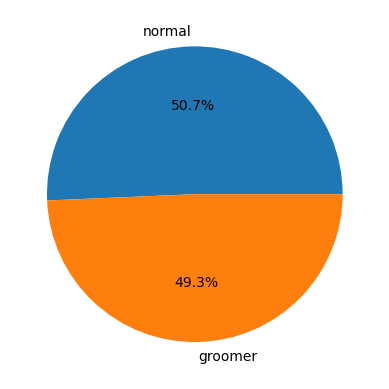

In [28]:
plt.pie(df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
plt.show()

In [29]:
df_train_UnderSampled.filter(col('label')==1).select("merged_text").take(5)

[Row(merged_text='hi how r ya? was out with a buddy u miss me huh? so is that a new pic? cool wish u had a hot pic 2 c ;) its ok that was a nice pic so how u getting to b up late? oh my u rock sweety yeah baby u gonna rock my world? hehe is that gonna b a good time? yep as long as u feel good with it yeah so how should we start any ideas? yes hmm battery powered toy? u like oils? what else u might like? oh i dont mind so r u shy? was just going to see if u want me 2 put a move on u or u put one on me? if u r cool yeah and what kinda move u b ok with? yes :D gettin pen hey mapquest my drive 4 me? chickasha 73018 to u yeah k how many miles it say? and drive time? cool u r between altys and lawton right? ok so u gonna give me phone #? i wont k u might have to talk me to yr house just incase but want u 2 call me as soon as its clear xxxx dont lose it babe yes i know not sure what i will driveyet so idk y? not more than 1 so what u mostly excited about? hehe so what u gonna where? yeah then

In [30]:
test_df_final.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|  2895|
|    0|152233|
+-----+------+



## 4.2 Use SpaCy English language model to turn words into vectors

In [31]:
# Load the SpaCy en_core_web_md model
nlp = en_core_web_sm.load(disable=["tagger", "parser", "ner"])

@staticmethod
def get_spacy():

    if "nlp" not in globals():
        globals()["nlp"] = nlp

    return globals()["nlp"]

doc1 = nlp("i love my pet dog")
doc2 = nlp("Maggie is my lovable pet dog!")
print(doc1.vector.size)
print(doc2.vector.size)
print("output:" , doc1.similarity(doc2))

96
96
output: 0.6314009741542267


/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/tmp/ipykernel_6062/4032923053.py:16: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print("output:" , doc1.similarity(doc2))


In [32]:
vec1 = nlp("i love my pet dog").vector
vec1

array([-0.82228184, -0.52981013, -0.04199264,  0.21913071, -0.03065448,
       -0.14778526,  0.6752845 ,  0.45747596, -0.14300331, -0.4820497 ,
       -0.2199707 , -0.31105405,  0.2607569 , -0.00689734, -0.7084032 ,
        0.24738555, -0.16439562,  0.2179037 , -0.37804666,  0.02349054,
       -0.15068911,  0.864818  , -0.637645  , -0.65831524,  0.22553782,
       -0.20611453, -0.23222873,  0.22810598, -0.2578836 , -0.1370413 ,
        0.5942478 ,  0.10742517,  0.18177323, -0.38608572,  0.0901499 ,
       -0.31681603, -0.04888222,  0.0951063 , -0.7534274 ,  0.35248774,
        0.08509431,  0.61296135,  0.23663417,  0.60823727, -0.5434038 ,
       -0.51587856, -0.15613341,  1.0582231 ,  0.28102857, -0.16917507,
       -0.8407737 ,  0.72302425,  0.32085943, -0.61701334,  0.05886409,
       -0.35398296,  0.5053838 ,  0.5155953 , -0.41034406, -0.1209401 ,
        0.40065938,  0.00445629,  0.5080544 ,  0.11423705,  0.06736588,
       -0.06459552,  0.24383393,  0.3004192 , -0.18886861, -0.43

In [33]:
type(vec1)

numpy.ndarray

### Build PySpark UDF to convert words into vector

In [34]:
nlpUDF = udf(lambda x: nlp(x).vector.tolist(), ArrayType(FloatType()))

df_train_UnderSampled = df_train_UnderSampled.withColumn('array', nlpUDF(col('merged_text')))

In [35]:
arrayUDF = udf(lambda array: Vectors.dense(array), VectorUDT())

df_train_UnderSampled = df_train_UnderSampled.withColumn('vector', arrayUDF(col('array')))

In [36]:
df_train_UnderSampled = df_train_UnderSampled.withColumn('array_size', size(col('array')))

In [37]:
test_df_final = test_df_final.withColumn('array', nlpUDF(col('merged_text')))
test_df_final = test_df_final.withColumn('vector', arrayUDF(col('array')))
test_df_final = test_df_final.withColumn('array_size', size(col('array')))

In [38]:
df_train_UnderSampled.take(1)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


[Row(conversation_id='0029418593d4134557765d14be325904', source='PAN12-train', label=0, conversation_start_time='22:33', n_people_in_conversation=1, type_conversation='Monologue', merged_text='sees one more Member response', merged_text_id='3f2e2531201cfbf853f16f668132eaf2: sees one more Member response', n_texts=1, array=[-0.3521425127983093, 0.08794703334569931, -0.10352931171655655, 0.05174877494573593, 0.008875275030732155, -0.2493605613708496, 0.19533273577690125, 0.6353193521499634, -0.22615401446819305, -0.0937582477927208, -0.06020350381731987, 0.06666779518127441, -0.3654279112815857, -0.47838473320007324, 0.4886876046657562, 0.3875822424888611, -0.7582265138626099, 0.32570576667785645, 0.2397572100162506, 0.03450951725244522, 0.08112430572509766, 0.6197803020477295, -0.03768032789230347, -0.04226129129528999, 0.045730482786893845, -0.7000465989112854, 0.08351993560791016, 0.5006964802742004, 0.7205625176429749, -0.6155064105987549, 0.021028995513916016, 0.3990761339664459, 0.

In [39]:
df_train_UnderSampled.filter(col("array_size") != 96).show()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


+--------------------+-----------+-----+-----------------------+------------------------+-----------------+-----------+--------------+-------+-----+------+----------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|merged_text|merged_text_id|n_texts|array|vector|array_size|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+-----------+--------------+-------+-----+------+----------+
|296b5fe667a3acb29...|PAN12-train|    1|                  16:26|                       1|        Monologue|           |              |      0|   []|    []|         0|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+-----------+--------------+-------+-----+------+----------+



### Remove samples which failed to convert into vctors

In [40]:
df_train_UnderSampled = df_train_UnderSampled.filter(col("array_size") == 96)

In [41]:
df_train_UnderSampled.groupBy('label').count().show()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


+-----+-----+
|label|count|
+-----+-----+
|    0| 2655|
|    1| 2583|
+-----+-----+



In [42]:
test_df_final = test_df_final.filter(col("array_size") == 96)

In [43]:
test_df_final.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|  2882|
|    0|152219|
+-----+------+



# 5 Build Model

##5.1 Simple Logistic Regression as Baseline

1) Use SpaCy word vectors as X and Labels as Y

2) Split spark df into training and validation sets

3) Build a simple Logistic Regression model and feed tokens into the model



In [44]:
dataset = df_train_UnderSampled.select(["vector","label"])
dataset = dataset.withColumnRenamed("vector", "features")
dataset.show()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.3521425127983...|    0|
|[0.10005491971969...|    0|
|[-0.0199431777000...|    0|
|[-0.4120956361293...|    0|
|[-0.4802114367485...|    0|
|[-0.0332721807062...|    0|
|[-0.1740683168172...|    0|
|[-0.0729374736547...|    0|
|[-0.1329477727413...|    0|
|[0.00380337238311...|    0|
|[-0.4028329849243...|    0|
|[-0.7814432978630...|    0|
|[-0.0590497590601...|    0|
|[-0.5636925101280...|    0|
|[-0.1837033182382...|    0|
|[0.07788052409887...|    0|
|[0.06216672807931...|    0|
|[-0.3217445909976...|    0|
|[-0.2823950350284...|    0|
|[-0.2286850959062...|    0|
+--------------------+-----+
only showing top 20 rows



In [45]:
test_set = test_df_final.select(["vector","label"])
test_set = test_set.withColumnRenamed("vector", "features")
test_set.show()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.4497839212417...|    0|
|[-0.0624015592038...|    0|
|[-0.2680500149726...|    0|
|[0.03563661500811...|    0|
|[-0.1016811951994...|    0|
|[-0.3309876024723...|    0|
|[-0.3858698010444...|    0|
|[-0.8366982936859...|    0|
|[-0.0423891544342...|    1|
|[0.05255183205008...|    0|
|[-0.0573445372283...|    0|
|[-0.3639622628688...|    0|
|[-0.2806627452373...|    0|
|[-0.0440953522920...|    0|
|[-0.6009455919265...|    0|
|[-0.1698518544435...|    0|
|[-0.4964128732681...|    0|
|[-0.1951097100973...|    0|
|[-0.6065414547920...|    0|
|[-0.2286946177482...|    0|
+--------------------+-----+
only showing top 20 rows



### Build a Logistic Regression Model with 80-20 validation split

In [46]:
lr = LogisticRegression()
# Build our ML pipeline
pipeline = Pipeline(stages=[lr])

In [47]:
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=3, metricLabel=1)
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=grid, evaluator=evaluator, trainRatio=0.80, parallelism=1, seed=1234)

### Start Model Training

In [48]:
start_time = time.time()
tvsModel = tvs.fit(dataset)
stop_time = time.time()
print(f"Training time: {stop_time - start_time}s")
tvsModel.getTrainRatio()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
24/03/02 22:50:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline i

Training time: 241.54346799850464s


0.8

### F-beta validatoin score with just simpe 80-20 split with training and validation:

In [49]:
tvsModel.validationMetrics

[0.0, 0.8085446196845678]

## 5.2 Let's try to do 5-fold cross-validation

In [50]:
(trainingData, validationData) = dataset.randomSplit([0.8, 0.2], seed = 100)

In [51]:
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=3, metricLabel=1)
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5, parallelism=1, seed=1234)

In [52]:
start_time = time.time()
cvModel = cv.fit(trainingData)
stop_time = time.time()
print(f"Training time: {stop_time - start_time}s")

24/03/02 23:02:30 WARN BlockManager: Asked to remove block broadcast_207_piece0, which does not exist


Training time: 692.5241198539734s


In [53]:
cvModel.avgMetrics

[0.0, 0.8077897139144847]

In [54]:
print("Training F-beta3 score: ", cvModel.avgMetrics[1])

Training F-beta3 score:  0.8077897139144847


In [55]:
# We are going to use sklearn to evalute the results on validation dataset

preds = cvModel.transform(validationData)

preds_df = preds.select('label',"prediction").toPandas()

preds_df['prediction'] = preds_df['prediction'].apply(lambda x : int(x))

print (classification_report(preds_df['label'], preds_df['prediction']))

              precision    recall  f1-score   support

           0       0.74      0.59      0.66       509
           1       0.67      0.80      0.73       527

    accuracy                           0.70      1036
   macro avg       0.71      0.70      0.69      1036
weighted avg       0.71      0.70      0.70      1036



In [56]:
f_beta3_score = fbeta_score(preds_df['label'], preds_df['prediction'], average='binary', beta=3, pos_label=1)

In [57]:
print("Validation F-beta3 score: ", f_beta3_score)

Validation F-beta3 score:  0.785554728220402


## 5.3 Run against the Test Set

In [58]:
# We are going to use sklearn to evalute the results on test dataset

preds_test = cvModel.transform(test_set)

preds_test_df = preds_test.select('label',"prediction").toPandas()

preds_test_df['prediction'] = preds_test_df['prediction'].apply(lambda x : int(x))

print (classification_report(preds_test_df['label'], preds_test_df['prediction']))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84    152219
           1       0.05      0.82      0.10      2882

    accuracy                           0.73    155101
   macro avg       0.52      0.77      0.47    155101
weighted avg       0.98      0.73      0.83    155101



In [59]:
f_beta3_test_score = fbeta_score(preds_test_df['label'], preds_test_df['prediction'], average='binary', beta=3, pos_label=1)

In [60]:
print("Test F-beta3 score: ", f_beta3_test_score)

Test F-beta3 score:  0.33944914708030766
